# 네이버 뉴스 제목 크롤링

In [5]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

# 검색어 및 기본 설정
query = "발표준비"
encoded_query = requests.utils.quote(query)
base_url = "https://search.naver.com/search.naver"
start = 1
titles = []

# 500개 이상의 기사 제목을 가져오기 위한 반복문
while len(titles) < 500:
    params = {
        "where": "news",
        "query": query,
        "start": start,
    }
    
    # 요청 보내기
    response = requests.get(base_url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    
    if response.status_code != 200:
        print("페이지 요청 실패:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")
    
    # 기사 제목 추출
    news_items = soup.select(".news_tit")
    
    if not news_items:
        print("더 이상 기사가 없습니다.")
        break

    for item in news_items:
        title = item.get_text()
        titles.append(title)
        
        if len(titles) >= 500:
            break

    start += 10  # 네이버 뉴스는 10개씩 페이지네이션됨
    time.sleep(1)  # 요청 간격 조정 (서버 부하 방지)

# 데이터 저장
df = pd.DataFrame(titles, columns=["제목"])
df.to_csv("naver_news_titles.csv", index=False, encoding="utf-8-sig")

print(f"총 {len(titles)}개의 기사 제목을 저장하였습니다.")

총 500개의 기사 제목을 저장하였습니다.


# 네이버 블로그 글 제목 크롤링

In [29]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd

# 네이버 블로그 검색 결과 URL
URL = "https://search.naver.com/search.naver?sm=tab_hty.top&ssc=tab.blog.all&query=%EB%B0%9C%ED%91%9C+%EC%A4%80%EB%B9%84&oquery=%EB%B0%9C%ED%91%9C%EC%A4%80%EB%B9%84&tqi=i9CvJwqVOZossC%2BImAKssssssl4-241964"

# Chrome 옵션 설정
options = Options()
options.add_argument("--headless")  # 브라우저를 띄우지 않고 실행 (백그라운드 실행)
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--window-size=1920,1080")

# ChromeDriver 실행 (자동 다운로드)
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
driver.get(URL)

# 스크롤 내리기 함수
def scroll_to_bottom(driver, max_attempts=30):
    """페이지 끝까지 스크롤을 내리는 함수"""
    scroll_heights = set()
    attempts = 0
    
    while attempts < max_attempts:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  # 로딩 대기
        new_height = driver.execute_script("return document.body.scrollHeight")

        if new_height in scroll_heights:
            break  # 같은 높이가 반복되면 종료
        scroll_heights.add(new_height)
        attempts += 1

# 스크롤 내리기 실행 (두 번 실행하여 최대로 로드)
scroll_to_bottom(driver)
time.sleep(2)  # 추가 대기
scroll_to_bottom(driver)

# 페이지 HTML 가져오기
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

# 블로그 글 크롤링 (href, 제목)
blogs = []
for link in soup.select("a.title_link"):  # "title_link" 클래스를 가진 a 태그 찾기
    title = link.get_text(strip=True)  # 제목 (innerText)
    url = link.get("href")  # 블로그 링크 (href 속성)
    blogs.append({"Title": title, "URL": url})

# 데이터 저장
df = pd.DataFrame(blogs)
df.to_csv("naver_blog_posts.csv", index=False, encoding="utf-8-sig")

print(f"{len(blogs)}개의 블로그 글이 'naver_blog_posts.csv'에 저장되었습니다.")

# Selenium 종료
driver.quit()

137개의 블로그 글이 'naver_blog_posts.csv'에 저장되었습니다.


In [30]:
df

,Title,URL
0,애크로뱃 PPT PDF 변환 기능으로 대학발표자료준비하기,https://blog.naver.com/soary81/223772587906
1,발음 교정으로발표준비완벽하게,https://blog.naver.com/haofiz/223796686958
2,포항 농막 설치 새롭게 신제품발표 준비중,https://blog.naver.com/cjh9435/223793882874
3,청년전용창업자금발표준비및 사례 여러분도 가능합니다,https://blog.naver.com/bizupjhk2515/223417365822
4,[Canva x 생성형 AI] 포럼 영어발표 준비!,https://blog.naver.com/ruma012/223599514366
...,...,...
132,[수성구 범어동 중등미술 까메오] 학생들이 직접준비한 서양미술사발표수업,https://blog.naver.com/ccamcca/223749335065
133,뤼튼 AI 이제 발표대본발표준비도움까지!,https://blog.naver.com/moonnufo/223692851705
134,사회(민주주의의 발전과 시민 참여) 구글 프레젠테이션발표,https://blog.naver.com/intothelee/223799806845
135,저발표1등했어요. (10만원 get),https://blog.naver.com/kim_cheese_v/223793922825


# 워드클라우드 및 네트워크 분석

## 명사 추출

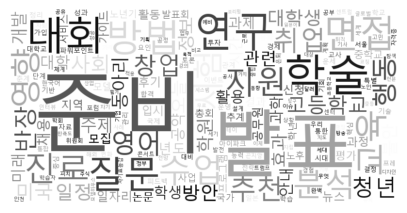

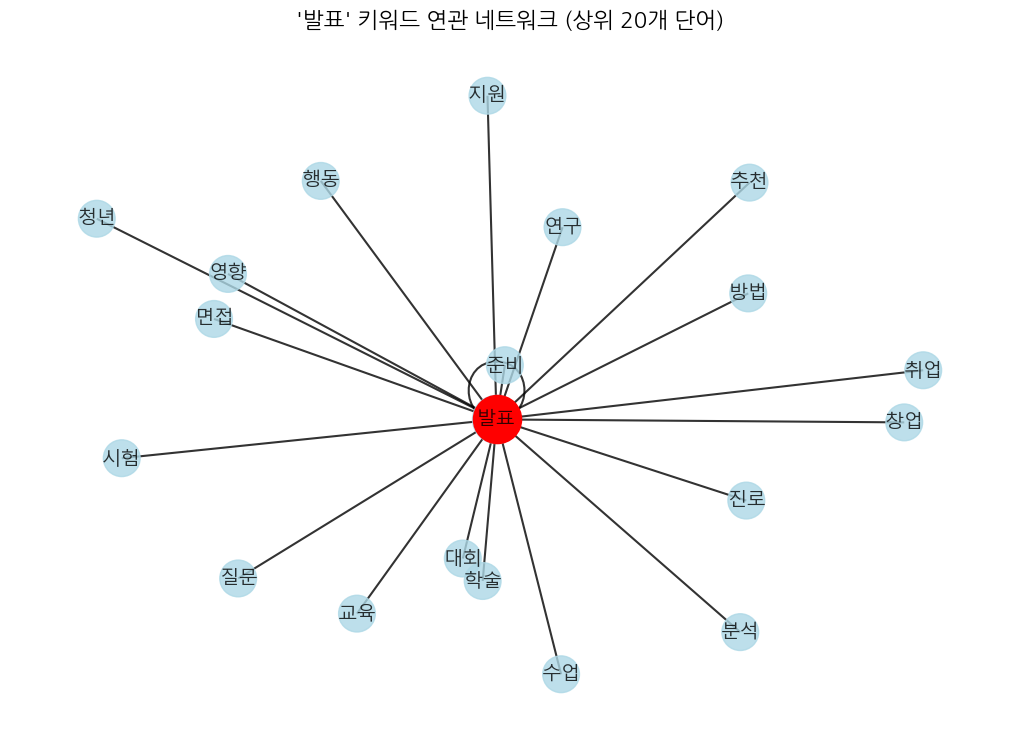

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
from collections import Counter
from itertools import combinations
from konlpy.tag import Okt
import koreanize_matplotlib
import re

# 1. CSV 파일 로드 함수
def load_data(csv_file):
    """CSV 파일을 불러와 데이터프레임으로 변환"""
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
    return df

# 2. 텍스트 전처리 함수
def preprocess_text(text):
    """한글만 남기고 불용어 제거"""
    text = re.sub(r"[^가-힣\s]", "", text)  # 한글 이외 문자 제거
    okt = Okt()
    words = okt.nouns(text)  # 명사 추출
    stopwords = ['대한', '한국', '통일', '선거', '정책']  # 불용어 목록 추가 가능
    words = [word for word in words if word not in stopwords and len(word) > 1]  # 불용어 제거 및 한 글자 단어 제외
    return words

# 3. 워드클라우드 생성 함수
def generate_wordcloud(words):
    """워드클라우드 생성"""
    word_freq = Counter(words)
    wordcloud = WordCloud(
        font_path="malgun.ttf",
        background_color="white",
        width=800,
        height=400,
        colormap="gray"  # 흑백톤 설정
    )
    wordcloud.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# 4. 네트워크 분석 함수
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from itertools import combinations

def generate_keyword_network(words, target_word="발표", top_n=20):
    """특정 키워드와의 연관 단어 중 상위 N개만 네트워크 그래프로 시각화 (글자 크기 및 색상 강조)"""
    word_pairs = list(combinations(words, 2))  # 단어 쌍 생성
    pair_freq = Counter(word_pairs)  # 단어 쌍 빈도 계산
    
    # "발표"와 연결된 단어들만 필터링
    related_words = {}
    for (word1, word2), freq in pair_freq.items():
        if word1 == target_word:
            related_words[word2] = freq
        elif word2 == target_word:
            related_words[word1] = freq

    # 연결 강도가 높은 순으로 정렬하여 상위 N개 선택
    top_related = dict(sorted(related_words.items(), key=lambda x: x[1], reverse=True)[:top_n])

    # 네트워크 그래프 생성
    G = nx.Graph()
    
    for word, freq in top_related.items():
        G.add_edge(target_word, word, weight=freq)  # "발표"와 관련 단어 연결

    # 노드 크기 설정 (중앙 "발표" 노드는 크기 고정)
    node_sizes = {node: G.degree(node) * 700 for node in G.nodes()}  
    node_sizes[target_word] = 1200  # "발표" 크기 고정 (너무 커지지 않도록 조정)

    # 네트워크 그래프 시각화 (색상 및 글자 크기 조정)
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)  # 그래프 레이아웃 설정
    
    # 노드 및 엣지 그리기
    nx.draw(G, pos, with_labels=True, font_family="Malgun Gothic", 
            node_size=[node_sizes[node] for node in G.nodes()],
            node_color="lightblue", edge_color="black", alpha=0.8, 
            font_size=14, width=1.5)  # 글씨 크기 및 대비 강조

    # 강조 표시 (중앙 노드 "발표" 키워드)
    if target_word in G.nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=[target_word], 
                               node_color="red", node_size=1200)  # "발표" 강조
    
    plt.title(f"'{target_word}' 키워드 연관 네트워크 (상위 {top_n}개 단어)", fontsize=16)
    plt.show()

# 5. 실행 파이프라인
def main(csv_file):
    """전체 데이터 분석 실행"""
    df = load_data(csv_file)  # CSV 파일 로드
    all_words = []
    
    for title in df["title"]:  # 모든 제목에 대해 전처리
        all_words.extend(preprocess_text(str(title)))
    
    generate_wordcloud(all_words)  # 워드클라우드 실행
    generate_keyword_network(all_words)  # 네트워크 분석 실행

# 실행 예시
csv_file = "../../data/csv/collection.csv" 
main(csv_file)

In [ ]:
import matplotlib.pyplot as plt

# 데이터 준비
labels = ['내성적 성격', '실수에 대한 압박감', '준비 부족', '무대 공포증', '질문의 대응이 어려워서']
sizes = [31.3, 25.0, 14.6, 12.5, 10.4]

# 어두운 회색 계열 색상 (톤만 약간 다르게)

# 파이차트 그리기
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}  # 조각 경계선 검정색
)
ax.axis('equal')  # 원형 유지
plt.title('발표 전 불안감의 원인 (어두운 회색톤)', fontsize=14)

plt.show()


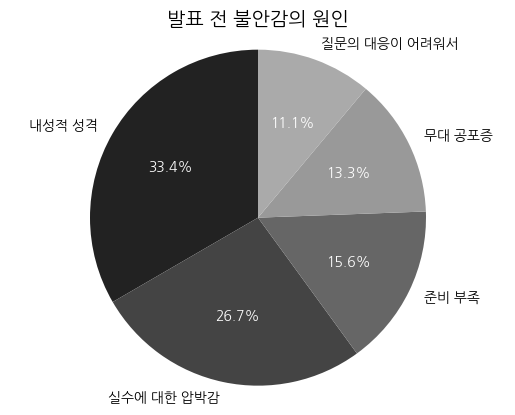

In [10]:
import matplotlib.pyplot as plt

# 데이터 준비
labels = ['내성적 성격', '실수에 대한 압박감', '준비 부족', '무대 공포증', '질문의 대응이 어려워서']
sizes = [31.3, 25.0, 14.6, 12.5, 10.4]
colors = ['#222222', '#444444', '#666666', '#999999', '#AAAAAA']

# 파이차트 그리기
fig, ax = plt.subplots()

# 파이차트 + 퍼센트 레이블 변수로 받기
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)

# 퍼센트 글자색 흰색으로 설정
for autotext in autotexts:
    autotext.set_color('white')

ax.axis('equal')  # 원형 유지
plt.title('발표 전 불안감의 원인', fontsize=14)

plt.show()

## 형용사 추출

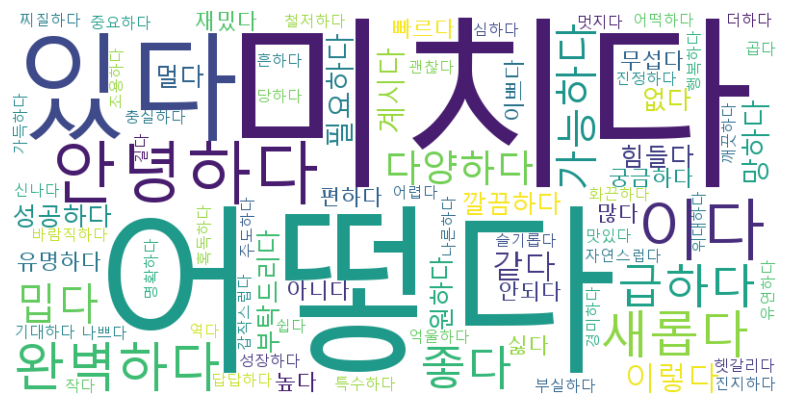

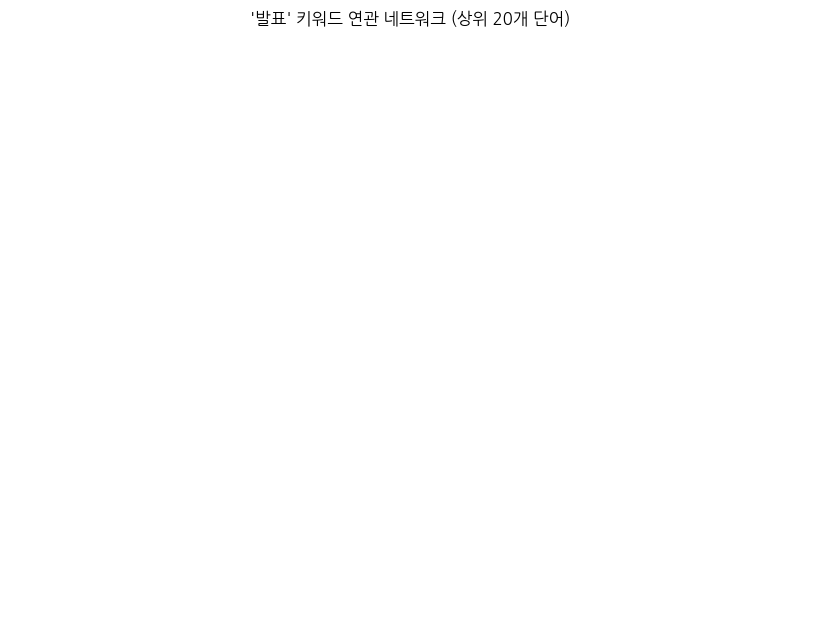

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
from collections import Counter
from itertools import combinations
from konlpy.tag import Okt
import koreanize_matplotlib
import re

# 1. CSV 파일 로드 함수
def load_data(csv_file):
    """CSV 파일을 불러와 데이터프레임으로 변환"""
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
    return df

# 2. 텍스트 전처리 함수
def preprocess_text(text):
    """한글만 남기고 형용사만 추출"""
    text = re.sub(r"[^가-힣\s]", "", text)  # 한글 이외 문자 제거
    okt = Okt()
    
    # 형용사만 추출
    words = [word for word, tag in okt.pos(text, norm=True, stem=True) if tag == "Adjective"]
    
    stopwords = ['대한', '한국', '통일', '선거', '정책']  # 불용어 목록 추가 가능
    words = [word for word in words if word not in stopwords and len(word) > 1]  # 불용어 제거 및 한 글자 단어 제외
    
    return words

# 3. 워드클라우드 생성 함수
def generate_wordcloud(words):
    """워드클라우드 생성"""
    word_freq = Counter(words)
    wordcloud = WordCloud(font_path="malgun.ttf", background_color="white", width=800, height=400)
    wordcloud.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# 4. 네트워크 분석 함수
def generate_keyword_network(words, target_word="발표", top_n=20):
    """특정 키워드와의 연관 단어 중 상위 N개만 네트워크 그래프로 시각화 (중앙 노드 크기 고정)"""
    word_pairs = list(combinations(words, 2))  # 단어 쌍 생성
    pair_freq = Counter(word_pairs)  # 단어 쌍 빈도 계산
    
    # "발표"와 연결된 단어들만 필터링
    related_words = {}
    for (word1, word2), freq in pair_freq.items():
        if word1 == target_word:
            related_words[word2] = freq
        elif word2 == target_word:
            related_words[word1] = freq

    # 연결 강도가 높은 순으로 정렬하여 상위 N개 선택
    top_related = dict(sorted(related_words.items(), key=lambda x: x[1], reverse=True)[:top_n])

    # 네트워크 그래프 생성
    G = nx.Graph()
    
    for word, freq in top_related.items():
        G.add_edge(target_word, word, weight=freq)  # "발표"와 관련 단어 연결

    # 노드 크기 설정 (중앙 "발표" 노드는 크기 고정)
    node_sizes = {node: G.degree(node) * 700 for node in G.nodes()}  
    node_sizes[target_word] = 1000  # "발표" 크기 고정 (너무 커지지 않도록 조정)

    # 네트워크 그래프 시각화
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # 그래프 레이아웃 설정
    nx.draw(G, pos, with_labels=True, font_family="Malgun Gothic", 
            node_size=[node_sizes[node] for node in G.nodes()], edge_color="gray", alpha=0.7, font_size=12)

    # 강조 표시 (중앙 노드 "발표" 키워드)
    if target_word in G.nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=[target_word], 
                               node_color="red", node_size=1000)  # "발표" 크기 고정
    
    plt.title(f"'{target_word}' 키워드 연관 네트워크 (상위 {top_n}개 단어)")
    plt.show()

# 5. 실행 파이프라인
def main(csv_file):
    """전체 데이터 분석 실행"""
    df = load_data(csv_file)  # CSV 파일 로드
    all_words = []
    
    for title in df["title"]:  # 모든 제목에 대해 전처리
        all_words.extend(preprocess_text(str(title)))
    
    generate_wordcloud(all_words)  # 워드클라우드 실행
    generate_keyword_network(all_words)  # 네트워크 분석 실행

# 실행 예시
csv_file = "../../data/csv/collection.csv" 
main(csv_file)

# csv 데이터 병합

In [8]:
from bs4 import BeautifulSoup
import pandas as pd
import os

def parsing(df,site):
    """ `BeautifulSoup`을 사용하여 HTML 태그 제거 후 기존 데이터프레임에 반영하고 저장 """

    def clean_html(text):
        """HTML 태그 제거"""
        if pd.isna(text):  
            return ""
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text().strip()  

    df['title'] = df['Title'].apply(clean_html)
    df = df.drop("Title", axis=1)
    df = df.rename(columns={"title" : "title", "URL" : "link"})


    save_dir = "../data/csv"
    csv_file_name = f"naver_{site}.csv"
    save_path = os.path.join(save_dir, csv_file_name)

    os.makedirs(save_dir, exist_ok=True)

    df.to_csv(save_path, index=False, encoding="utf-8-sig")

    print(f"데이터가 정제되어 저장되었습니다: {save_path}")
    
    return df 

In [10]:
csv_path = "../../data/csv"
blog = pd.read_csv(f"{csv_path}/naver_blog_posts.csv")

blog = parsing(blog, "blog")
blog = blog[['title', 'link']]
blog

데이터가 정제되어 저장되었습니다: ../data/csv\naver_blog.csv


C:\Users\user\AppData\Local\Temp\ipykernel_17268\2096812692.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,title,link
0,애크로뱃 PPT PDF 변환 기능으로 대학발표자료준비하기,https://blog.naver.com/soary81/223772587906
1,발음 교정으로발표준비완벽하게,https://blog.naver.com/haofiz/223796686958
2,포항 농막 설치 새롭게 신제품발표 준비중,https://blog.naver.com/cjh9435/223793882874
3,청년전용창업자금발표준비및 사례 여러분도 가능합니다,https://blog.naver.com/bizupjhk2515/223417365822
4,[Canva x 생성형 AI] 포럼 영어발표 준비!,https://blog.naver.com/ruma012/223599514366
...,...,...
132,[수성구 범어동 중등미술 까메오] 학생들이 직접준비한 서양미술사발표수업,https://blog.naver.com/ccamcca/223749335065
133,뤼튼 AI 이제 발표대본발표준비도움까지!,https://blog.naver.com/moonnufo/223692851705
134,사회(민주주의의 발전과 시민 참여) 구글 프레젠테이션발표,https://blog.naver.com/intothelee/223799806845
135,저발표1등했어요. (10만원 get),https://blog.naver.com/kim_cheese_v/223793922825


In [11]:
search_list = ['webkr', 'doc', 'kin', "cafearticle"]

site_dict = {}
for site in search_list:
    site_dict[site] = pd.read_csv(f"{csv_path}/naver_{site}.csv")

site_dict['blog'] = blog
site_dict['doc']

,title,link
0,성공적인 발표를 위한 PPT 작성법 및 발표 준비,http://academic.naver.com/article.naver?doc_id...
1,원격 발표 준비를 위한 스마트폰 기반 비동기 피드백 공유 인터페이스,http://academic.naver.com/article.naver?doc_id...
2,원격 발표 준비를 위한 스마트폰 기반 비동기 피드백 공유 인터페이스,http://academic.naver.com/article.naver?doc_id...
3,원격 발표 준비를 위한 스마트폰 기반 비동기 피드백 공유 인터페이스,http://academic.naver.com/article.naver?doc_id...
4,발표준비 안내,http://academic.naver.com/article.naver?doc_id...
...,...,...
495,발표불안에 대한 비디오 피드백의 효과 : 중재변인과 매개변인,http://academic.naver.com/article.naver?doc_id...
496,과업중심 준비학습을 통한 초등영어 역할극 지도에 관한 연구,http://academic.naver.com/article.naver?doc_id...
497,「유리동물원」의 연출적 접근방법 연구: 제작 발표를 중심으로,http://academic.naver.com/article.naver?doc_id...
498,"팬데믹과 여성폭력 현장의 전환, 우리는 무엇을 준비해야 하는가? [좌담]",http://academic.naver.com/article.naver?doc_id...
